<a href="https://colab.research.google.com/github/37743/NTAI-Project/blob/main/Arabic_Handwriting_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

yousefgomaa43_arabic_ocr_project_dataset_path = kagglehub.dataset_download('yousefgomaa43/arabic-ocr-project-dataset')
yousefgomaa43_arabic_fonts_path = kagglehub.dataset_download('yousefgomaa43/arabic-fonts')

print('Data source import complete.')

Using Colab cache for faster access to the 'arabic-ocr-project-dataset' dataset.


100%|██████████| 330k/330k [00:00<00:00, 61.5MB/s]

Extracting files...
Data source import complete.


# NTAI - Arabic Handwriting Generation Project

ID: 320210207

Dataset was initialized using another kaggle notebook, some pre-processing is continued on this one.

## TODO:
- Use arabic handwritten text transformer to recognize fragments of the paragraph and compare them with ground truth.
- Train CVAE/CGAN/transformer on fragments of text + label

In [1]:
%%capture

!pip install -qqq -U peft transformers bitsandbytes trl accelerate safetensors --no-cache-dir;

In [ ]:
# import shutil
# from pathlib import Path

# working_dir = Path("/kaggle/working")

# if not working_dir.exists():
#     print(f"{working_dir} does not exist.")
# else:
#     for child in working_dir.iterdir():
#         try:
#             if child.is_dir():
#                 shutil.rmtree(child)
#                 print(f"Removed directory: {child}")
#             else:
#                 child.unlink()
#                 print(f"Removed file: {child}")
#         except Exception as e:
#             print(f"Failed to remove {child}: {e}")

In [16]:
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import json
import time


In [6]:
df = pd.read_csv("/kaggle/input/arabic-ocr-project-dataset/labels/paragraph_labels_cleaned.csv")

df.head(10)

,image_path,paragraph_number,confidence,method
0,/content/Arabic_OCR_Dataset/imgs_scans/1.jpg,1.0,1.000,manual
1,/content/Arabic_OCR_Dataset/imgs_scans/10.jpg,10.0,1.000,manual
2,/content/Arabic_OCR_Dataset/imgs_scans/11.jpg,11.0,1.000,topband/bin
3,/content/Arabic_OCR_Dataset/imgs_scans/12.jpg,12.0,1.000,topband/gray
4,/content/Arabic_OCR_Dataset/imgs_scans/13.jpg,13.0,0.998,topband/bin
5,/content/Arabic_OCR_Dataset/imgs_scans/14.jpg,14.0,0.999,topband/bin
6,/content/Arabic_OCR_Dataset/imgs_scans/15.jpg,15.0,0.880,topband/gray
7,/content/Arabic_OCR_Dataset/imgs_scans/16.jpg,16.0,1.000,topband/gray
8,/content/Arabic_OCR_Dataset/imgs_scans/17.jpg,17.0,0.995,topband/gray
9,/content/Arabic_OCR_Dataset/imgs_scans/18.jpg,18.0,0.696,topband/gray


In [7]:
df['image_path'] = df['image_path'].apply(lambda x: x.replace('/content/Arabic_OCR_Dataset', '/kaggle/input/arabic-ocr-project-dataset'))

json_path = '/kaggle/input/arabic-ocr-project-dataset/labels/arabic_paragraphs_all.json'
with open(json_path, 'r', encoding='utf-8') as f:
    paragraphs = json.load(f)

paragraph_df = pd.DataFrame(paragraphs)

df = df.merge(paragraph_df[['paragraph_number', 'text']], on='paragraph_number', how='left')

df.head(10)

,image_path,paragraph_number,confidence,method,text
0,/kaggle/input/arabic-ocr-project-dataset/imgs_...,1.0,1.000,manual,تعد الهندسة البرمجية مجالا يجمع بين العلم والف...
1,/kaggle/input/arabic-ocr-project-dataset/imgs_...,10.0,1.000,manual,تلعب تقنيات الحوسبة السحابية دورا مهما في تطوي...
2,/kaggle/input/arabic-ocr-project-dataset/imgs_...,11.0,1.000,topband/bin,الذكاء الاصطناعي اصبح جزءا ال يتجزأ من الهندسة...
3,/kaggle/input/arabic-ocr-project-dataset/imgs_...,12.0,1.000,topband/gray,تطوير البرمجيات مفتوحة المصدر يسهم في خلق بيئة...
4,/kaggle/input/arabic-ocr-project-dataset/imgs_...,13.0,0.998,topband/bin,الواجهات البرمجية تسهل التكامل بين الانظمة الم...
5,/kaggle/input/arabic-ocr-project-dataset/imgs_...,14.0,0.999,topband/bin,البرمجة الشيئية تعد من اكثر الانماط استخداما ف...
6,/kaggle/input/arabic-ocr-project-dataset/imgs_...,15.0,0.880,topband/gray,في عالم تطوير البرمجيات تعد ادارة البيانات من ...
7,/kaggle/input/arabic-ocr-project-dataset/imgs_...,16.0,1.000,topband/gray,تطوير تطبيقات الويب يتطلب استخدام تقنيات متقدم...
8,/kaggle/input/arabic-ocr-project-dataset/imgs_...,17.0,0.995,topband/gray,في مجال تطوير تطبيقات الهواتف الذكية يعتمد الم...
9,/kaggle/input/arabic-ocr-project-dataset/imgs_...,18.0,0.696,topband/gray,برمجيات انترنت الاشياء اصبحت من اكثر المجالات ...


In [9]:
print(df[['image_path', 'confidence']].sort_values(by='confidence', ascending=True))

                                            image_path  confidence
65   /kaggle/input/arabic-ocr-project-dataset/imgs_...       0.001
494  /kaggle/input/arabic-ocr-project-dataset/imgs_...       0.001
497  /kaggle/input/arabic-ocr-project-dataset/imgs_...       0.002
506  /kaggle/input/arabic-ocr-project-dataset/imgs_...       0.005
491  /kaggle/input/arabic-ocr-project-dataset/imgs_...       0.005
..                                                 ...         ...
651  /kaggle/input/arabic-ocr-project-dataset/imgs_...       1.000
652  /kaggle/input/arabic-ocr-project-dataset/imgs_...       1.000
653  /kaggle/input/arabic-ocr-project-dataset/imgs_...       1.000
654  /kaggle/input/arabic-ocr-project-dataset/imgs_...       1.000
0    /kaggle/input/arabic-ocr-project-dataset/imgs_...       1.000

[655 rows x 2 columns]


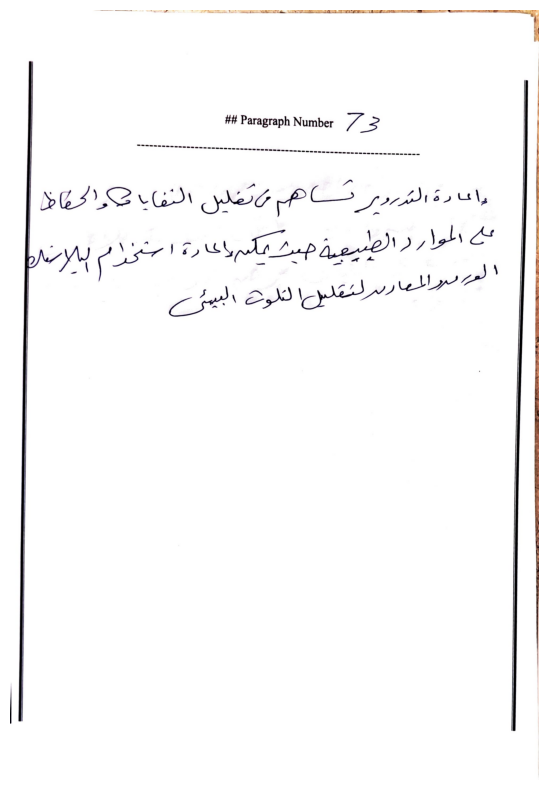

Enter new paragraph number for /kaggle/input/arabic-ocr-project-dataset/imgs_scans/Image 82.png (current: 73.0) or type 'skip' to skip: skip
Skipped updating paragraph number for /kaggle/input/arabic-ocr-project-dataset/imgs_scans/Image 82.png. Confidence set to 1.0.
Finished processing images with confidence less than 0.8.


In [17]:
for index, row in df.iterrows():
    if row['confidence'] < 0.8:
        image_path = row['image_path']
        print(f"Processing image: {image_path}")

        try:
            clear_output(wait=True) # Clear the output before showing the next image
            img = mpimg.imread(image_path)
            plt.figure(figsize=(10, 10)) # Adjust figure size as needed
            plt.imshow(img)
            plt.axis('off')  # Hide axes
            plt.show()

            time.sleep(2) # Add a 2-second delay

            while True:
                try:
                    new_paragraph_number_input = input(f"Enter new paragraph number for {image_path} (current: {row['paragraph_number']}) or type 'skip' to skip: ")
                    if new_paragraph_number_input.lower() == 'skip':
                        df.at[index, 'confidence'] = 1.0
                        print(f"Skipped updating paragraph number for {image_path}. Confidence set to 1.0.")
                        break
                    else:
                        new_paragraph_number = int(new_paragraph_number_input)
                        # Check if the entered paragraph number exists in the original paragraphs data
                        if new_paragraph_number in paragraph_df['paragraph_number'].values:
                            df.at[index, 'paragraph_number'] = new_paragraph_number
                            df.at[index, 'confidence'] = 1.0
                            df.at[index, 'method'] = 'manual'
                            print(f"Updated {image_path} with new paragraph number: {new_paragraph_number}")
                            break # Exit the inner loop if input is valid
                        else:
                            print("Invalid paragraph number. Please enter a number that exists in the original paragraph list or 'skip'.")
                except ValueError:
                    print("Invalid input. Please enter an integer for the paragraph number or 'skip'.")

        except FileNotFoundError:
            print(f"Error: Image file not found at {image_path}")
        except Exception as e:
            print(f"An error occurred while processing {image_path}: {e}")

print("Finished processing images with confidence less than 0.8.")

In [21]:
# Reload the original paragraphs to ensure we have the correct text for each paragraph number
json_path = '/kaggle/input/arabic-ocr-project-dataset/labels/arabic_paragraphs_all.json'
with open(json_path, 'r', encoding='utf-8') as f:
    paragraphs = json.load(f)

paragraph_df = pd.DataFrame(paragraphs)

# Drop the old 'text' column
if 'text' in df.columns:
    df = df.drop(columns=['text'])

# Merge with paragraph_df to get the updated text based on the current paragraph_number
df = df.merge(paragraph_df[['paragraph_number', 'text']], on='paragraph_number', how='left')

df.head(10)

,image_path,paragraph_number,confidence,method,text
0,/kaggle/input/arabic-ocr-project-dataset/imgs_...,1.0,1.000,manual,تعد الهندسة البرمجية مجالا يجمع بين العلم والف...
1,/kaggle/input/arabic-ocr-project-dataset/imgs_...,10.0,1.000,manual,تلعب تقنيات الحوسبة السحابية دورا مهما في تطوي...
2,/kaggle/input/arabic-ocr-project-dataset/imgs_...,11.0,1.000,topband/bin,الذكاء الاصطناعي اصبح جزءا ال يتجزأ من الهندسة...
3,/kaggle/input/arabic-ocr-project-dataset/imgs_...,12.0,1.000,topband/gray,تطوير البرمجيات مفتوحة المصدر يسهم في خلق بيئة...
4,/kaggle/input/arabic-ocr-project-dataset/imgs_...,13.0,0.998,topband/bin,الواجهات البرمجية تسهل التكامل بين الانظمة الم...
5,/kaggle/input/arabic-ocr-project-dataset/imgs_...,14.0,0.999,topband/bin,البرمجة الشيئية تعد من اكثر الانماط استخداما ف...
6,/kaggle/input/arabic-ocr-project-dataset/imgs_...,15.0,0.880,topband/gray,في عالم تطوير البرمجيات تعد ادارة البيانات من ...
7,/kaggle/input/arabic-ocr-project-dataset/imgs_...,16.0,1.000,topband/gray,تطوير تطبيقات الويب يتطلب استخدام تقنيات متقدم...
8,/kaggle/input/arabic-ocr-project-dataset/imgs_...,17.0,0.995,topband/gray,في مجال تطوير تطبيقات الهواتف الذكية يعتمد الم...
9,/kaggle/input/arabic-ocr-project-dataset/imgs_...,18.0,1.000,topband/gray,برمجيات انترنت الاشياء اصبحت من اكثر المجالات ...


In [22]:
df.to_csv("/kaggle/working/arabic-ocr-project-dataset_copy/labels/paragraph_labels_cleaned.csv", index=False)
print("DataFrame saved successfully.")

DataFrame saved successfully.


In [23]:
!pip -q install kaggle

from google.colab import files
uploaded = files.upload()  # pick kaggle.json

import os, json, shutil, pathlib
pathlib.Path('/root/.kaggle').mkdir(parents=True, exist_ok=True)
shutil.move('kaggle.json', '/root/.kaggle/kaggle.json')
os.chmod('/root/.kaggle/kaggle.json', 0o600)

with open('/root/.kaggle/kaggle.json') as f:
    token = json.load(f)
print("Kaggle username:", token.get("username"))


Saving kaggle.json to kaggle.json
Kaggle username: yousefgomaa43


In [27]:
from pathlib import Path

DATA_DIR = Path("/kaggle/working/arabic-ocr-project-dataset_copy")

DATASET_SLUG = "arabic-ocr-project-dataset"
DATASET_TITLE = "Arabic OCR Project Dataset"
OWNER_USERNAME = "yousefgomaa43"

metadata_path = DATA_DIR / "dataset-metadata.json"
if not metadata_path.exists():
    with open(metadata_path, "w", encoding="utf-8") as f:
        f.write(f'''{{
  "title": "{DATASET_TITLE}",
  "id": "{OWNER_USERNAME}/{DATASET_SLUG}",
  "licenses": [{{"name": "CC0-1.0"}}]
}}''')
    print("✅ Created dataset-metadata.json")
else:
    print("✅ dataset-metadata.json already exists")

!kaggle datasets version -p "$DATA_DIR" -m "Added and cleaned all dataset requirements" -q -r zip

print("✅ Dataset folders reorganized and new version uploaded successfully.")

✅ Created dataset-metadata.json
Dataset version is being created. Please check progress at https://www.kaggle.com/datasets/yousefgomaa43/arabic-ocr-project-dataset
✅ Dataset folders reorganized and new version uploaded successfully.


In [28]:
df = pd.read_csv("/kaggle/working/arabic-ocr-project-dataset_copy/labels/paragraph_labels_cleaned.csv")
print(df[['image_path', 'confidence']].sort_values(by='confidence', ascending=True))

                                            image_path  confidence
620  /kaggle/input/arabic-ocr-project-dataset/imgs_...       0.800
51   /kaggle/input/arabic-ocr-project-dataset/imgs_...       0.806
203  /kaggle/input/arabic-ocr-project-dataset/imgs_...       0.811
364  /kaggle/input/arabic-ocr-project-dataset/imgs_...       0.812
274  /kaggle/input/arabic-ocr-project-dataset/imgs_...       0.814
..                                                 ...         ...
651  /kaggle/input/arabic-ocr-project-dataset/imgs_...       1.000
652  /kaggle/input/arabic-ocr-project-dataset/imgs_...       1.000
653  /kaggle/input/arabic-ocr-project-dataset/imgs_...       1.000
654  /kaggle/input/arabic-ocr-project-dataset/imgs_...       1.000
0    /kaggle/input/arabic-ocr-project-dataset/imgs_...       1.000

[655 rows x 2 columns]


In [19]:
import shutil
import os

source_dir = '/kaggle/input/arabic-ocr-project-dataset'
destination_dir = '/kaggle/working/arabic-ocr-project-dataset_copy'

# Create the destination directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# Copy the contents of the source directory to the destination directory
try:
    shutil.copytree(source_dir, destination_dir, dirs_exist_ok=True)
    print(f"Dataset copied from {source_dir} to {destination_dir}")
except Exception as e:
    print(f"Error copying dataset: {e}")

Dataset copied from /kaggle/input/arabic-ocr-project-dataset to /kaggle/working/arabic-ocr-project-dataset_copy


In [7]:
print(df.paragraph_number.value_counts().sum(),'\n\n\n', df.paragraph_number.value_counts())

655 


 paragraph_number
1.0      37
2.0      35
3.0      32
4.0      29
5.0      28
         ..
136.0     1
173.0     1
137.0     1
208.0     1
88.0      1
Name: count, Length: 170, dtype: int64


In [30]:
import os
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from io import BytesIO
import glob
from pathlib import Path
import numpy as np

In [31]:
def merge_bounding_boxes(boxes):
    """
    Merges bounding boxes where one is inside the other (i.e., one box's center is inside another).
    """
    merged_boxes = []
    for i, box in enumerate(boxes):
        merged = False
        x1, y1, w1, h1 = box
        for j, other_box in enumerate(boxes):
            if i != j:
                x2, y2, w2, h2 = other_box

                if (x1 >= x2 and y1 >= y2 and x1 + w1 <= x2 + w2 and y1 + h1 <= y2 + h2):
                    new_box = (
                        min(x1, x2),
                        min(y1, y2),
                        max(x1 + w1, x2 + w2) - min(x1, x2),
                        max(y1 + h1, y2 + h2) - min(y1, y2)
                    )
                    if new_box not in merged_boxes:
                        merged_boxes.append(new_box)
                    merged = True
                    break
        if not merged:
            merged_boxes.append(box)

    return merged_boxes

def add_padding_to_bounding_boxes(boxes, padding_x=5, padding_y=0):
    """
    Adds padding to the bounding boxes (increases their size).
    Args:
    - boxes: List of bounding boxes [(x, y, w, h), ...]
    - padding_x: The amount of padding to add to the width of the bounding box.
    - padding_y: The amount of padding to add to the height of the bounding box.

    Returns:
    - A list of bounding boxes with added padding.
    """
    padded_boxes = []
    for (x, y, w, h) in boxes:
        x0 = max(x - padding_x, 0)
        y0 = max(y - padding_y, 0)
        x1 = x + w + padding_x
        y1 = y + h + padding_y
        padded_boxes.append((x0, y0, x1 - x0, y1 - y0))
    return padded_boxes

def crop_handwriting_with_subplots(
    image_path,
    out_dir,
    top_exclude_ratio=0.05,
    bottom_exclude_ratio=0.15,
    side_margin_ratio=0.01,
    blackhat_kernel=(35, 25),
    line_h_len_ratio=0.15,
    line_v_len_ratio=0.15,
    close_kernel=(35, 10),
    merge_kernel=(35, 15),
    min_cc_area=1200,
    save_union=False,
    save_crop=False,
    visualize=False,
    consistent_size=(512, 512)
):
    """
    Crops only the middle handwritten text (no title, no pillars), merges bounding boxes,
    excludes horizontal lines, and outputs the union crop of all boxes resized to a consistent size.
    """
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    img = cv2.imread(str(image_path))
    if img is None:
        raise FileNotFoundError(image_path)
    H, W = img.shape[:2]

    y_top_cut = int(H * top_exclude_ratio)
    y_bottom_cut = int(H * (1 - bottom_exclude_ratio))
    x_left_cut = int(W * side_margin_ratio)
    x_right_cut = int(W * (1 - side_margin_ratio))

    img_cropped = img[y_top_cut:y_bottom_cut, x_left_cut:x_right_cut]

    gray = cv2.cvtColor(img_cropped, cv2.COLOR_BGR2GRAY)

    thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,81,17)
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25,1))

    remove_horizontal = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, horizontal_kernel, iterations=3)
    cnts = cv2.findContours(remove_horizontal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    mask = np.zeros(gray.shape, np.uint8)
    for c in cnts:
        cv2.drawContours(mask, [c], -1, (255,255,255),6)

    img_clean = cv2.inpaint(img_cropped, mask, 3, cv2.INPAINT_TELEA)

    gray = cv2.cvtColor(img_clean, cv2.COLOR_BGR2GRAY)

    bh = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT,
                          cv2.getStructuringElement(cv2.MORPH_RECT, blackhat_kernel))

    _, bw = cv2.threshold(bh, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    hlen = max(35, int(W * line_h_len_ratio))
    vlen = max(35, int(H * line_v_len_ratio))
    h_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (hlen, 3))
    v_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, vlen))
    lines_h = cv2.morphologyEx(bw, cv2.MORPH_OPEN, h_kernel)
    lines_v = cv2.morphologyEx(bw, cv2.MORPH_OPEN, v_kernel)
    lines = cv2.bitwise_or(lines_h, lines_v)
    mask = cv2.bitwise_and(bw, cv2.bitwise_not(lines))

    closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE,
                              cv2.getStructuringElement(cv2.MORPH_RECT, close_kernel), iterations=2)

    num, lab, stats, _ = cv2.connectedComponentsWithStats(closed, connectivity=8)
    keep = np.zeros_like(closed)
    for i in range(1, num):
        x, y, w, h, area = stats[i]
        if area >= min_cc_area: keep[lab == i] = 255

    merged = cv2.dilate(keep, cv2.getStructuringElement(cv2.MORPH_RECT, merge_kernel), iterations=1)

    boxes = []
    num_boxes, lab_boxes, stats_boxes, _ = cv2.connectedComponentsWithStats(merged, connectivity=8)
    for i in range(1, num_boxes):
        x, y, w, h, area = stats_boxes[i]
        if area >= min_cc_area:
            if h / w > 1.1:
                continue  # Skip adding this box if it's extremely vertical or horizontal
            boxes.append((x, y, w, h))


    boxes = add_padding_to_bounding_boxes(boxes, padding_x=40, padding_y=10)

    boxes.sort(key=lambda b: b[1])

    if save_crop:
        sentence_crops = []
        for idx, (x, y, w, h) in enumerate(boxes):
            # Crop each bounding box and save
            crop = img_cropped[y:y+h, x:x+w]
            crop_filename = out_dir / f"{idx + 1}.png"
            cv2.imwrite(str(crop_filename), crop)
            sentence_crops.append(str(crop_filename))

    union_resized = None
    union_path = None

    xs = [x for x, _, _, _ in boxes]
    ys = [y for _, y, _, _ in boxes]
    xe = [x + w for x, _, w, _ in boxes]
    ye = [y + h for _, y, _, h in boxes]
    x0 = max(min(xs) - 10, 0)
    y0 = max(min(ys) - 10, 0)
    x1 = min(max(xe) + 10, W)
    y1 = min(max(ye) + 10, H)

    union = img_cropped[y0:y1, x0:x1]

    union_resized = cv2.resize(union, consistent_size, interpolation=cv2.INTER_LINEAR)

    if save_union:
        union_path = out_dir / "union_crop_resized.png"
        cv2.imwrite(str(union_path), union_resized)

    if visualize:
        fig, axs = plt.subplots(3, 3, figsize=(15, 15))
        axs = axs.ravel()
        stages = [
            ("Original", img),
            ("Gray", gray),
            ("Black-hat", bh),
            ("Binary", bw),
            ("No Lines", mask),
            ("Closed", closed),
            ("Merged", merged)
        ]
        for i, (title, im) in enumerate(stages):
            if i >= len(axs): break
            axs[i].imshow(im if im.ndim == 2 else cv2.cvtColor(im, cv2.COLOR_BGR2RGB),
                          cmap="gray")
            axs[i].set_title(title)
            axs[i].axis("off")

        vis = img_cropped.copy()
        for (x, y, w, h) in boxes:
            cv2.rectangle(vis, (x, y), (x + w, y + h), (0, 255, 0), 3)
        axs[-2].imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
        axs[-2].set_title("Detected boxes")
        axs[-2].axis("off")

        axs[-1].imshow(cv2.cvtColor(union_resized, cv2.COLOR_BGR2RGB))
        axs[-1].set_title("Union crop resized")
        axs[-1].axis("off")

        plt.tight_layout()
        plt.show()

    return union_resized, boxes, str(union_path)

In [ ]:
img_path = "/kaggle/input/arabic-ocr-project-dataset/imgs_scans/Image 181.png"
boxes, crops, union = crop_handwriting_with_subplots(img_path, out_dir="/kaggle/working/", visualize=True)

In [ ]:
img_path = "/kaggle/input/arabic-ocr-project-dataset/imgs_scans/Image 180.png"
boxes, crops, union = crop_handwriting_with_subplots(img_path, out_dir="/kaggle/working/", visualize=True)

In [ ]:
img_path = "/kaggle/input/arabic-ocr-project-dataset/imgs_scans/Image 448.jpg"
boxes, crops, union = crop_handwriting_with_subplots(img_path, out_dir="/kaggle/working/", visualize=True)

In [ ]:
img_path = "/kaggle/input/arabic-ocr-project-dataset/imgs_scans/Image 489.jpg"
boxes, crops, union = crop_handwriting_with_subplots(img_path, out_dir="/kaggle/working/", visualize=True)

In [ ]:
img_path = "/kaggle/input/arabic-ocr-project-dataset/imgs_scans/Image 521.jpg"
boxes, crops, union = crop_handwriting_with_subplots(img_path, out_dir="/kaggle/working/", visualize=True)

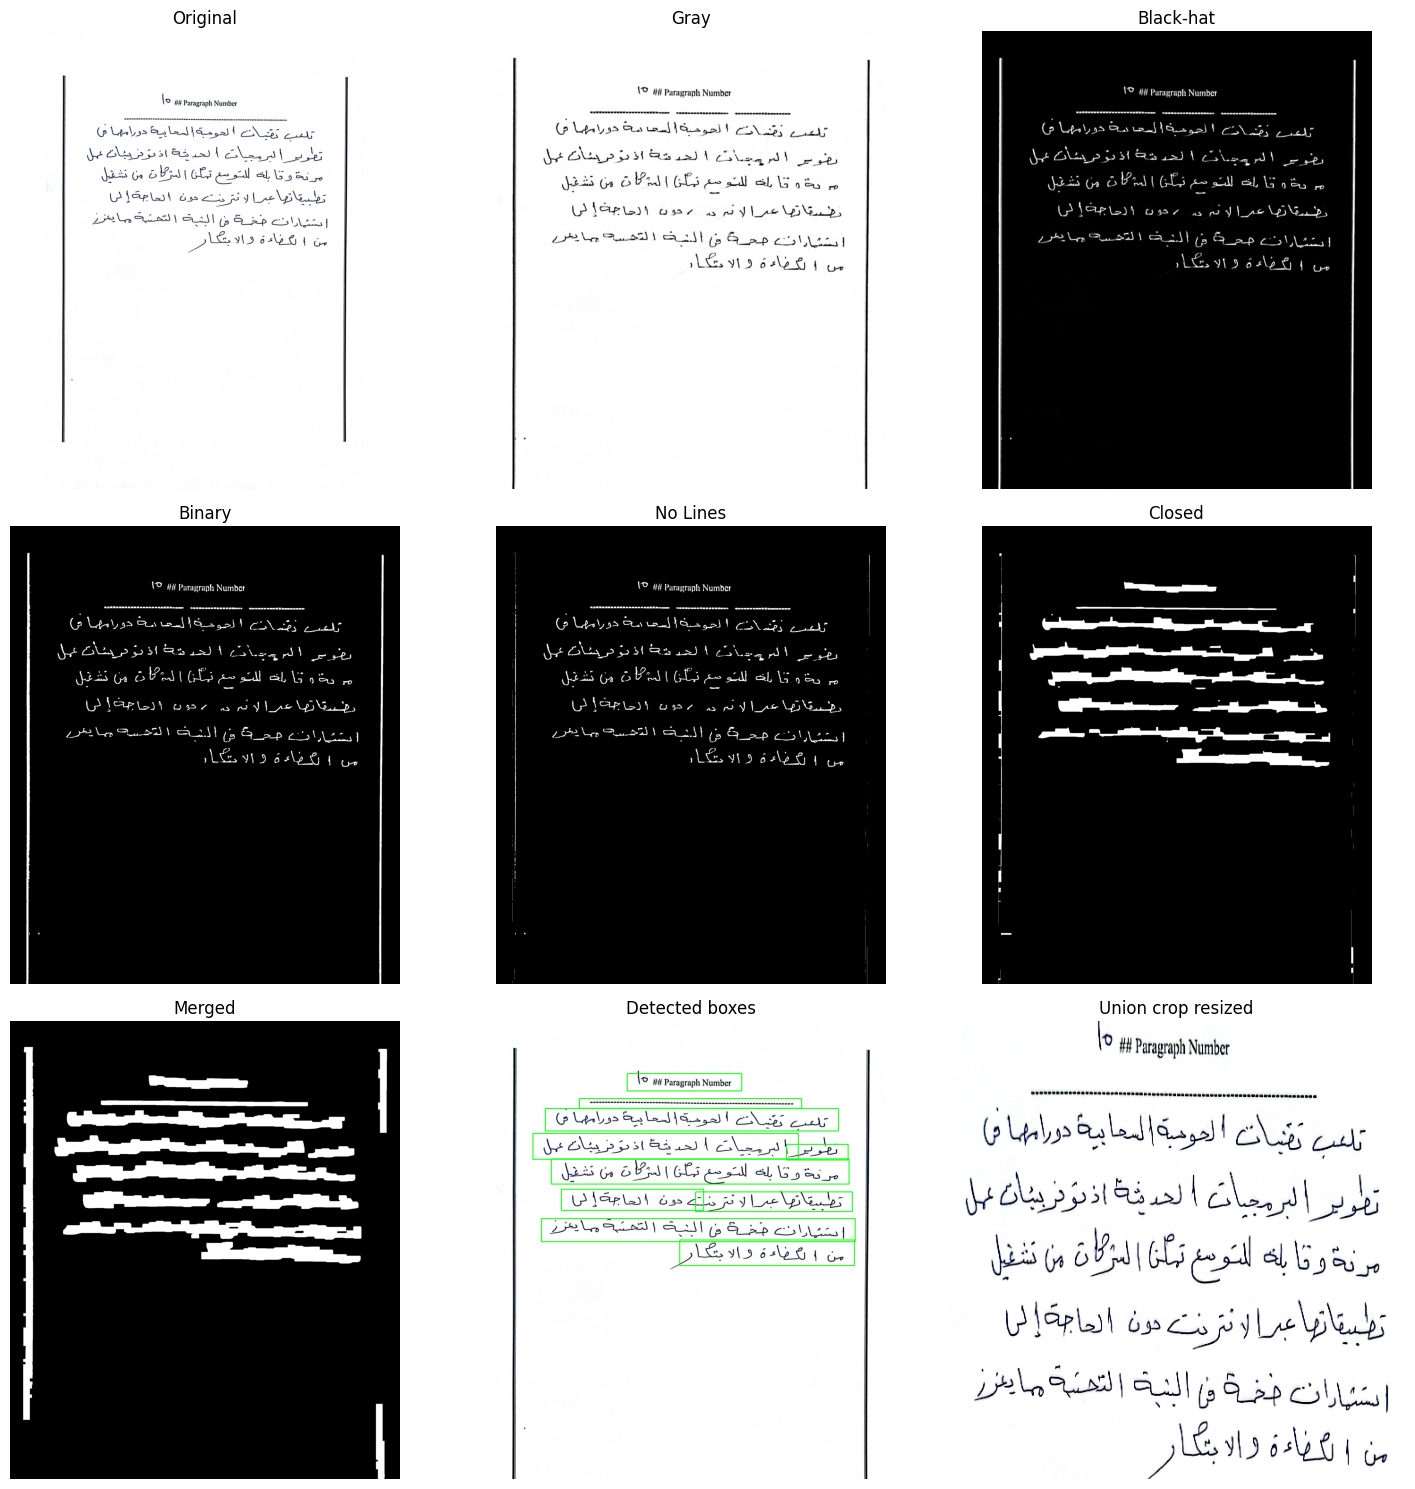

In [32]:
img_path = "/kaggle/input/arabic-ocr-project-dataset/imgs_scans/10.jpg"
boxes, crops, union = crop_handwriting_with_subplots(img_path, out_dir="/kaggle/working/", save_crop=True, visualize=True)

In [ ]:
for _, row in df.iterrows():
    image_path = row['image_path']
    paragraph_number = int(row['paragraph_number'])
    image_name = Path(image_path).stem
    out_dir = Path("/kaggle/working") / str(paragraph_number) / image_name
    out_dir.mkdir(parents=True, exist_ok=True)

    sentence_images, detected_boxes, union_path = crop_handwriting_with_subplots(
        image_path,
        out_dir,
        save_union=True,
        save_crop=True,
        visualize=False,
        consistent_size=(512, 512)
    )

In [33]:
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
import torch
from PIL import Image
from typing import List, Dict

def process_vision_info(messages: List[dict]):
    image_inputs = []
    video_inputs = []
    for message in messages:
        if isinstance(message["content"], list):
            for item in message["content"]:
                if item["type"] == "image":
                    image = item["image"]
                    if isinstance(image, str):
                        image = Image.open(image).convert("RGB")
                    elif isinstance(image, Image.Image):
                        pass
                    else:
                        raise ValueError(f"Unsupported image type: {type(image)}")
                    image_inputs.append(image)
                elif item["type"] == "video":
                    video_inputs.append(item["video"])
    return image_inputs if image_inputs else None, video_inputs if video_inputs else None

# Load model and processor
model_name = "sherif1313/Arabic-handwritten-OCR-4bit-Qwen2.5-VL-3B-v1"
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto"
)

# Setup processor
min_pixels = 512 * 28 * 28
max_pixels = 2048 * 28 * 28
processor = AutoProcessor.from_pretrained(
    model_name,
    min_pixels=min_pixels,
    max_pixels=max_pixels
)

def extract_text_from_image(image_path):
    try:
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "image", "image": image_path},
                    {"type": "text", "text": "Read all texts in this image and extract them as they are. Don't miss any word."},
                ],
            }
        ]

        text = processor.apply_chat_template(
            messages, tokenize=False, add_generation_prompt=True
        )
        image_inputs, video_inputs = process_vision_info(messages)

        inputs = processor(
            text=[text],
            images=image_inputs,
            videos=video_inputs,
            padding=True,
            return_tensors="pt",
        ).to(model.device)

        generated_ids = model.generate(
            **inputs,
            max_new_tokens=1000,
            do_sample=False,
            pad_token_id=processor.tokenizer.pad_token_id
        )

        input_len = inputs.input_ids.shape[1]
        output_text = processor.batch_decode(
            generated_ids[:, input_len:],
            skip_special_tokens=True,
            clean_up_tokenization_spaces=False
        )[0]

        return output_text.strip()

    except Exception as e:
        return f"Error processing image: {e}"

In [34]:
image_path = "/kaggle/working/6.png"  # Replace with your image path
extracted_text = extract_text_from_image(image_path)
print("Extracted Text:")
print(extracted_text)

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Extracted Text:
مرنة وقابلة للتوسع تمكنا اعترضات من تشغيل


In [35]:
df[df['image_path'] == '/kaggle/input/arabic-ocr-project-dataset/imgs_scans/10.jpg']['text'].iloc[0]


'تلعب تقنيات الحوسبة السحابية دورا مهما في تطوير البرمجيات الحديثة اذ توفر بيئات عمل مرنة وقابلة للتوسع تمكن الشركات من تشغيل تطبيقاتها عبر الانترنت دون الحاجة الى استثمارات ضخمة في البنية التحتية مما يعزز من الكفاءة والابتكار'

In [36]:
import unicodedata
import re
from typing import Tuple, Optional

def strip_diacritics(s: str) -> str:
    # removes Arabic & Latin diacritics by stripping all combining marks
    # keeps base letters (good for noisy OCR / mixed scripts)
    nfkd = unicodedata.normalize("NFKD", s)
    return "".join(ch for ch in nfkd if not unicodedata.combining(ch))

def normalize_text(s: str, *, casefold: bool = True, rm_diacritics: bool = True) -> str:
    if rm_diacritics:
        s = strip_diacritics(s)
    s = unicodedata.normalize("NFKC", s)
    return s.casefold() if casefold else s

WORD_RE = re.compile(r"\S+")  # simple whitespace tokenization; preserves spans

def words_with_spans(text: str):
    """Return [(word, start, end), ...] where spans point into the original text."""
    return [(m.group(), m.start(), m.end()) for m in WORD_RE.finditer(text)]

def levenshtein(a: str, b: str) -> int:
    """Simple DP edit distance on strings (O(len(a)*len(b)))."""
    if a == b:
        return 0
    if not a:
        return len(b)
    if not b:
        return len(a)
    if len(a) > len(b):
        a, b = b, a
    prev = list(range(len(b) + 1))
    for i, ca in enumerate(a, 1):
        cur = [i]
        for j, cb in enumerate(b, 1):
            ins = cur[j-1] + 1
            dele = prev[j] + 1
            sub = prev[j-1] + (ca != cb)
            cur.append(min(ins, dele, sub))
        prev = cur
    return prev[-1]

def find_closest_sequence(
    query_text: str,
    paragraph_text: str,
    *,
    casefold: bool = True,
    rm_diacritics: bool = True,
) -> Tuple[Optional[str], Optional[Tuple[int, int]], int]:
    """
    Returns:
      - matched_substring (exact slice from original paragraph) or None
      - (start, end) span in original paragraph, or None
      - edit_distance (int)
    """
    q_words = [w for w, _, _ in words_with_spans(query_text)]
    if not q_words:
        return None, None, 0
    win_len = len(q_words)

    p_words_spans = words_with_spans(paragraph_text)
    p_words = [w for w, _, _ in p_words_spans]

    q_norm = normalize_text(" ".join(q_words), casefold=casefold, rm_diacritics=rm_diacritics)

    best = (None, None, float("inf"))  # (span, matched_substring, distance)

    for i in range(0, max(0, len(p_words) - win_len + 1)):
        w_slice = p_words_spans[i:i+win_len]
        start, end = w_slice[0][1], w_slice[-1][2]
        candidate_raw = paragraph_text[start:end]

        # normalize window
        cand_norm = normalize_text(" ".join(w for w, _, _ in w_slice),
                                   casefold=casefold, rm_diacritics=rm_diacritics)
        dist = levenshtein(q_norm, cand_norm)

        if dist < best[2]:
            best = ((start, end), candidate_raw, dist)
            if dist == 0:
                break

    if best[0] is None:
        return None, None, 0
    return best[1], best[0], int(best[2])

def remove_span_neatly(text: str, span: Tuple[int, int]) -> str:
    """Remove [start:end] and collapse any doubled whitespace that results."""
    start, end = span
    new_text = text[:start] + text[end:]
    new_text = re.sub(r"[ \t]{2,}", " ", new_text)
    new_text = re.sub(r" *(\n) *", r"\1", new_text)
    new_text = re.sub(r" +([,.;:!؟،])", r"\1", new_text)
    return new_text.strip()

def extract_and_remove_closest(
    query_text: str,
    paragraph_text: str,
    *,
    casefold: bool = True,
    rm_diacritics: bool = True,
) -> Tuple[Optional[str], str, int]:
    """
    Finds closest same-length word sequence to `query_text` in `paragraph_text`,
    returns (matched_substring, updated_paragraph, edit_distance).
    If nothing found (shouldn’t happen with non-empty inputs), matched_substring is None.
    """
    match, span, dist = find_closest_sequence(
        query_text,
        paragraph_text,
        casefold=casefold,
        rm_diacritics=rm_diacritics,
    )
    if match is None or span is None:
        return None, paragraph_text, dist
    updated = remove_span_neatly(paragraph_text, span)
    return match, updated, dist

In [37]:
paragraph = df[df['image_path'] == '/kaggle/input/arabic-ocr-project-dataset/imgs_scans/10.jpg']['text'].iloc[0]
query = extracted_text
found, new_paragraph, distance = extract_and_remove_closest(query, paragraph)

print("Query:", query)
print("Found :", found)
print("Edit distance:", distance)
print("Updated paragraph:\n", new_paragraph)

Query: مرنة وقابلة للتوسع تمكنا اعترضات من تشغيل
Found : مرنة وقابلة للتوسع تمكن الشركات من تشغيل
Edit distance: 4
Updated paragraph:
 تلعب تقنيات الحوسبة السحابية دورا مهما في تطوير البرمجيات الحديثة اذ توفر بيئات عمل تطبيقاتها عبر الانترنت دون الحاجة الى استثمارات ضخمة في البنية التحتية مما يعزز من الكفاءة والابتكار
